In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy
import math
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)


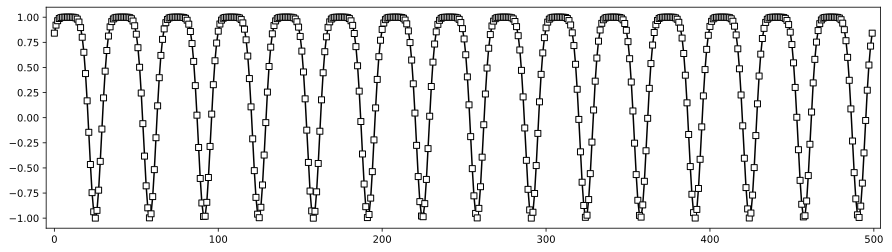

torch.Size([500])

In [49]:
# Create temporal sequence data
# Import the data
N = 500
time = torch.linspace(0, 30 * np.pi, N)

data = torch.sin(time + torch.cos(time))

plt.figure(figsize=(15, 4))
plt.plot(data.cpu(), "ks-", markerfacecolor="w")
plt.xlim([-5, N+4])
plt.show()
data.shape


In [50]:
## Create a class for the RNN DL model
class rnnnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        # print(f'Input Size: {input_size}, Hidden Layers: {num_hidden}, Number of Layers: {num_layers}')
        # RNN Layers
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # Linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x, h):
        # Run through the RNN Layer
        y, hidden = self.rnn(x, h) # There will be no explicit hidden state initialization
        # And the output (linear) layer
        y = self.out(y)

        return y, hidden


In [53]:
# Network parameters
input_size = 1 # Channels of data
num_hidden = 9 # Breadth of model (Number of units in hidden layers)
num_layers = 1 # Depth of model (number of stacks of hidden layers)
seqlength = 30 # Number of datapoints used for learning in each segments
batchsize = 1 # Note: The training code is actually hard coded to organize data into batchsize=1

# Create an instance of the model
net = rnnnet(input_size, num_hidden, num_layers)
X = torch.rand(seqlength, batchsize, input_size)
y, h = net(X, None)
print('X shape: ', X.shape)
print(
    'y Shape: ', y.shape
)  # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print('h shape: ', h.shape)


X shape:  torch.Size([30, 1, 1])
y Shape:  torch.Size([30, 1, 1])
h shape:  torch.Size([1, 1, 9])


In [42]:
# test the model with some data
somedata = data[:seqlength].view(seqlength, 1, 1)
print(somedata.shape)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]
print(f'Final value: {finalValue}')

lossfun = nn.MSELoss()
loss = lossfun(finalValue, data[seqlength].view(1, 1))
print(f'Loss: {loss}')


torch.Size([5, 1, 1])
Final value: tensor([[-0.2679]], device='cuda:0', grad_fn=<SelectBackward0>)
Loss: 1.6054314374923706


In [44]:
import sys
# Train the model and show performance
epochs = 500

# Create new instance of the model
net = rnnnet(input_size, num_hidden, num_layers)

optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

# Initialize losses
losses = np.zeros(epochs)
signAcc = np.zeros(epochs)

# Loop over epochs
for epoch in range(epochs):
    # Loop over data segments
    segLosses = []
    segAcc = []
    hiddenState = torch.zeros(num_layers, batchsize, num_hidden)
    # print(f'hidden state shape: {hiddenState}')

    for time in range(len(N)-seqlength):
        # Grab a snippet of data
        X = data[time: time+seqlength].view(seqlength, 1, 1)
        y = data[time+seqlength].view(1, 1)

        # Forward pass and loss
        yHat, hiddenState = net(X)
        finalValue = yHat[-1]
        loss = lossfun(finalValue, y) # Compare final value of output

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss from this segment
        segLosses.append(loss.cpu().item())

        # Also get the sigh accuracy
        trueSign = torch.squeeze(y).cpu().numpy()
        predSign = torch.squeeze(yHat).cpu().detach().numpy()
        accuracy = 100 * np.mean(trueSign == predSign)
        segAcc.append(accuracy)

    # Average losses from this epoch
    losses[epoch] = np.mean(segLosses)
    signAcc[epoch] = np.mean(segAcc)

    msg = f'Finished epoch {epoch + 1} / {epochs}'
    sys.stdout.write('\r' + msg + '\n')


Finished epoch 1 / 500
Finished epoch 2 / 500
Finished epoch 3 / 500
Finished epoch 4 / 500
Finished epoch 5 / 500
Finished epoch 6 / 500
Finished epoch 7 / 500
Finished epoch 8 / 500
Finished epoch 9 / 500
Finished epoch 10 / 500
Finished epoch 11 / 500
Finished epoch 12 / 500
Finished epoch 13 / 500
Finished epoch 14 / 500
Finished epoch 15 / 500
Finished epoch 16 / 500
Finished epoch 17 / 500
Finished epoch 18 / 500
Finished epoch 19 / 500
Finished epoch 20 / 500
Finished epoch 21 / 500
Finished epoch 22 / 500
Finished epoch 23 / 500
Finished epoch 24 / 500
Finished epoch 25 / 500
Finished epoch 26 / 500
Finished epoch 27 / 500
Finished epoch 28 / 500
Finished epoch 29 / 500
Finished epoch 30 / 500
Finished epoch 31 / 500
Finished epoch 32 / 500
Finished epoch 33 / 500
Finished epoch 34 / 500
Finished epoch 35 / 500
Finished epoch 36 / 500
Finished epoch 37 / 500
Finished epoch 38 / 500
Finished epoch 39 / 500
Finished epoch 40 / 500
Finished epoch 41 / 500
Finished epoch 42 / 500
F

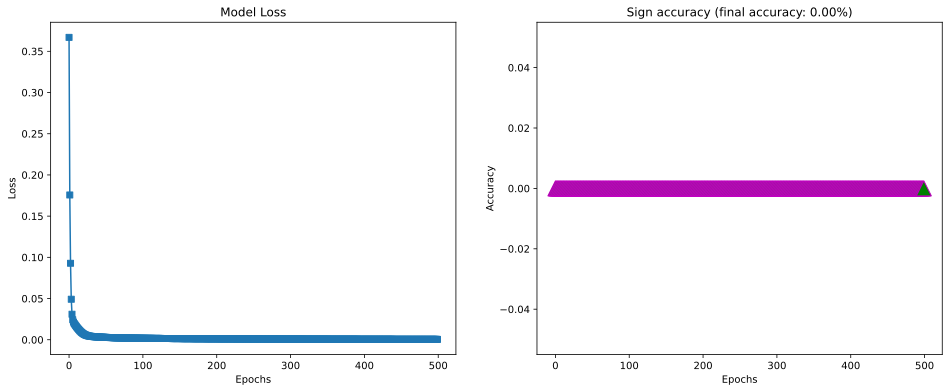

In [45]:
# Let's see how model did
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(losses, 's-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(signAcc, 'm^-', markerfacecolor='g', markersize=15)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Sign accuracy (final accuracy: %.2f%%)" % signAcc[-1])

plt.show()


In [46]:
# initialize hidden state
h = np.zeros((N, num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N - seqlength):

    # grab a snippet of data
    X = data[timei : timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, hh = net(X)
    yHat[timei + seqlength] = yy[-1]
    h[timei + seqlength, :] = hh.cpu().detach()


## compute sign-accuracy
truesign = np.sign(data.cpu().numpy())
predsign = np.sign(yHat)
signaccuracy = 100 * np.mean(truesign[seqlength:] == predsign[seqlength:])


## plot!
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(data.cpu(), "bs-", label="Actual data")
ax[0].plot(yHat, "ro-", label="Predicted")
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title("Sign accuracy = %.2f%%" % signaccuracy)
ax[0].legend()

ax[1].plot(data.cpu() - yHat, "k^")
ax[1].set_ylim([-1.1, 1.1])

ax[2].plot(data[seqlength:].cpu(), yHat[seqlength:], "mo")
ax[2].set_xlabel("Real data")
ax[2].set_ylabel("Predicted data")
r = np.corrcoef(data[seqlength:].cpu(), yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle("Performance on training data", fontweight="bold", fontsize=20, y=1.1)
plt.tight_layout()
plt.show()


TypeError: only integer scalar arrays can be converted to a scalar index

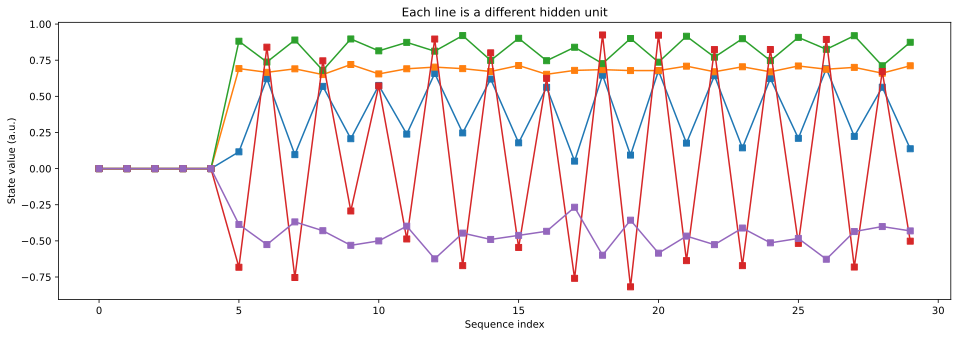

In [29]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16, 5))

plt.plot(h, "s-")
plt.xlabel("Sequence index")
plt.ylabel("State value (a.u.)")
plt.title("Each line is a different hidden unit")
plt.show()


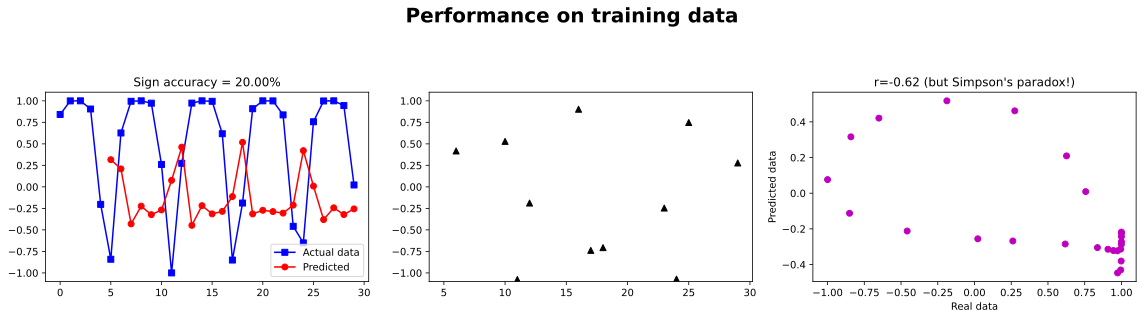

In [35]:
# Let's test on the new data
newdata = torch.zeros(N)
for i in range(N):
    newdata[i] = math.sin(i + math.cos(i))

data = newdata

# initialize hidden state
h = np.zeros((N, num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N - seqlength):

    # grab a snippet of data
    X = data[timei : timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, hh = net(X)
    yHat[timei + seqlength] = yy[-1]
    h[timei + seqlength, :] = hh.cpu().detach()


## compute sign-accuracy
truesign = np.sign(data.cpu().numpy())
predsign = np.sign(yHat)
signaccuracy = 100 * np.mean(truesign[seqlength:] == predsign[seqlength:])


## plot!
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(data.cpu(), "bs-", label="Actual data")
ax[0].plot(yHat, "ro-", label="Predicted")
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title("Sign accuracy = %.2f%%" % signaccuracy)
ax[0].legend()

ax[1].plot(data.cpu() - yHat, "k^")
ax[1].set_ylim([-1.1, 1.1])

ax[2].plot(data[seqlength:].cpu(), yHat[seqlength:], "mo")
ax[2].set_xlabel("Real data")
ax[2].set_ylabel("Predicted data")
r = np.corrcoef(data[seqlength:].cpu(), yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle("Performance on training data", fontweight="bold", fontsize=20, y=1.1)
plt.tight_layout()
plt.show()


tensor([ 0.2542,  0.0770,  0.2255,  0.8903, -0.3278]) range(0, 5)


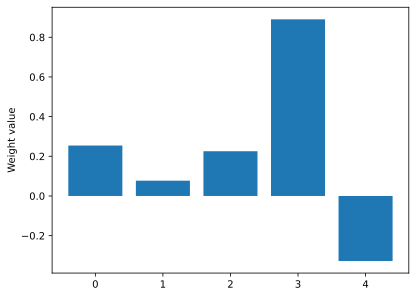

In [31]:
# plot the weights for the input->hidden layers
print(net.rnn.weight_ih_l0.cpu().detach().squeeze(), range(num_hidden))
plt.bar(range(num_hidden), net.rnn.weight_ih_l0.cpu().detach().squeeze())
plt.ylabel("Weight value")
plt.show()
